# Projet ARF : inpainting 
##### TREÜ Marc & KARMIM Yannis

## Préambule : régression linéaire, régression ridge et LASSO

In [1]:
import sys, os, warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

import numpy as np
import math
import sklearn
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing


def load_usps(filename):
    with open(filename,"r") as f:
        f.readline()
        data =[ [float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp = np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)


# Chargement des données USPS. 

trainX, trainY = load_usps('data/USPS_train.txt')
testX, testY = load_usps('data/USPS_test.txt')

#### Regression Linéaire

In [2]:
def fit_linear_regression(n1,n2,dataX,dataY):
    
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une régression linéaire ."""

    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)

    return LinearRegression(normalize=True).fit(X,Y)

In [3]:
# Choix des classes : 
n1 = 1
n2 = 7

reg = fit_linear_regression(n1,n2,trainX,trainY)

indice_classe = np.where(np.in1d(testY, [n1,n2]))
X_test = testX[indice_classe]
Y_test = np.where(testY[indice_classe] == n1, 1, -1)

Score calculé avec le coeficient de détermination R²

In [4]:
reg.score(X_test, Y_test)

-5.4150241635465626e+19

Score calculé avec la méthode plug-in

In [5]:
np.sum(np.sign(reg.predict(X_test)) == Y_test) / len(Y_test)

0.9708029197080292

In [6]:
def plugin_score(models, X_test, Y_test):
    return np.sum(np.sign(models.predict(X_test)) == Y_test) / len(Y_test)

#### Ridge Regression ( sans Cross Val ) 

In [41]:
def fit_ridge_regression(n1,n2,dataX,dataY,alpha=1.0):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)

    return Ridge(alpha=alpha).fit(X,Y)

ridge = fit_ridge_regression(n1,n2,trainX,trainY,alpha=1.0)
print("score avec la ridge régression :", plugin_score(ridge, X_test, Y_test))

score avec la ridge régression : 0.9878345498783455


#### Ridge Regression ( avec Cross Val )

In [42]:
def fit_ridge_regressionCV(n1,n2,dataX,dataY,nb_cv = 10, verbose=False):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression avec Cross Val."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)
    
    clf = RidgeCV(alphas=(0.1, 1, 5, 10, 20), cv = nb_cv)
    clf.fit(X,Y)
    
    if verbose:
        print("Meilleur alpha trouvé par Cross Validation : ",clf.alpha_)
    
    return clf 

ridgeCV = fit_ridge_regressionCV(n1, n2, trainX, trainY, verbose=True)
print("score avec la ridge régression + cross validation :",plugin_score(ridgeCV, X_test, Y_test))

Meilleur alpha trouvé par Cross Validation :  20.0
score avec la ridge régression + cross validation : 0.9854014598540146


#### LASSO 

In [9]:
def fit_LASSO(n1,n2,dataX,dataY,alpha = 0.001):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression avec Cross Val."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)
    clf = Lasso(alpha = alpha)
    clf.fit(X,Y)
    
    return clf 

lasso = fit_LASSO(n1,n2,trainX,trainY,alpha=0.1)
print("score avec lasso regression :", plugin_score(lasso, X_test, Y_test))

score avec lasso regression : 0.9635036496350365


#### LASSO + Cross Validation

In [10]:
def fit_LASSO_CV(n1,n2,dataX,dataY,nb_cv = 10, verbose=False):
    """Compare deux classes représentant les nombres n1 et n2
    en utilisant une Ridge Regression avec Cross Val."""
    
    indice_classe = np.where(np.in1d(dataY, [n1,n2]))
    X = dataX[indice_classe]
    Y = np.where(dataY[indice_classe] == n1, 1, -1)
    
    clf = LassoCV(cv = nb_cv)
    clf.fit(X,Y)
    if verbose:
        print("Meilleur alpha trouvé par Cross Validation : ",clf.alpha_)
    
    return clf 

lassoCV = fit_LASSO_CV(n1, n2, trainX, trainY, verbose=True)
print("score avec lasso regression + cross validation :",plugin_score(lassoCV, X_test, Y_test))

Meilleur alpha trouvé par Cross Validation :  0.0014878791090701493
score avec lasso regression + cross validation : 0.9829683698296837


In [11]:
import itertools

def calcule_all_result(trainX, trainY, testX, testY):
    
    # Combinaison de tous les classifieur classe i vs classe j : [(1, 2), (1, 3), ...]
    combinaison = [i for i in itertools.combinations([(j) for j in range(10)], 2)]
    
    # On fit les 5 models pour chaque classe i vs classe j
    models_regression = [fit_linear_regression(n[0], n[1], trainX, trainY) for n in combinaison]
    
    models_ridge = [fit_ridge_regression(n[0], n[1], trainX, trainY) for n in combinaison]
    models_ridgeCV = [fit_ridge_regressionCV(n[0], n[1], trainX, trainY) for n in combinaison]
    
    models_lasso = [fit_LASSO(n[0],n[1], trainX, trainY) for n in combinaison]
    models_lassoCV = [fit_LASSO_CV(n[0],n[1], trainX, trainY) for n in combinaison]
    
    models = [models_regression, models_ridge, models_ridgeCV, models_lasso, models_lassoCV]
    
    score_models_regression = []
    score_models_ridge = []
    score_models_ridgeCV = []
    score_models_lasso = []
    score_models_lassoCV = [] 
    
    for n in range(len(combinaison)):
        n1, n2 = combinaison[n]
        indice_classe = np.where(np.in1d(testY, [n1,n2]))
        X = testX[indice_classe]
        Y = np.where(testY[indice_classe] == n1, 1, -1)
        
        score_models_regression.append(plugin_score(models_regression[n], X, Y))
        score_models_ridge.append(plugin_score(models_ridge[n], X, Y))
        score_models_ridgeCV.append(plugin_score(models_ridgeCV[n], X, Y))
        score_models_lasso.append(plugin_score(models_lasso[n], X, Y))
        score_models_lassoCV.append(plugin_score(models_lassoCV[n], X, Y))

    scores = [score_models_regression, score_models_ridge, score_models_ridgeCV, score_models_lasso, score_models_lassoCV] 
    
    return models, scores

In [12]:
# Calcule trés long
models, scores = calcule_all_result(trainX, trainY, testX, testY)

In [13]:
def calcule_w_moyen(liste_modele):
    return sum(sum(abs(w) for w in liste_modele[i].coef_) / 256 for i in range(len(liste_modele))) / len(liste_modele)

def calcule_w_var(liste_modele):
    return np.var([[w for w in liste_modele[i].coef_ ] for i in range(len(liste_modele))])
    
def calcule_nombre_w_null(liste_modele):
    return sum(len(np.where(liste_modele[i].coef_ == 0)[0]) for i in range(len(liste_modele))) / len(liste_modele)

def calcule_score_moy(liste_score):
    return sum(liste_score) / len(liste_score)
    
def calcule_all(modeles, scores):
    return calcule_score_moy(scores), calcule_w_moyen(modeles), calcule_w_var(modeles), calcule_nombre_w_null(modeles)                           

In [46]:
resultat_reg = calcule_all(models[0], scores[0])
resultat_ridge = calcule_all(models[1], scores[1])
resultat_ridgeCV = calcule_all(models[2], scores[2])
resultat_lasso = calcule_all(models[3], scores[3])
resultat_lassoCV = calcule_all(models[4], scores[4])

resultat_all = [calcule_all(models[i], scores[i]) for i in range(5)]

def print_resultat(resultat):
    nom_reg = {0:"Régression simplement avec MSE", 1:"Régression avec regularisation l2 (Ridge)", 2:"Régression avec regularisation l2 + cross validation"
    ,3:"Régression avec regularisation l1 (Lasso)",4:"Régression avec regularisation l1 (Lasso) + cross validation"}
    
    for i in range(5):
        print(nom_reg[i],":\n\t\tscore moyen =", resultat[i][0], "\n\t\tpoid moyen des w =", resultat[i][1]
              , "\n\t\tvariance moyenne des w =", resultat[i][2], "\n\t\tnombre moyen de w à 0 =", resultat[i][3], "\n")


### Résultats

In [47]:
print_resultat(resultat_all)

Régression simplement avec MSE :
		score moyen = 0.9726377952540973 
		poid moyen des w = 554842134089.6156 
		variance moyenne des w = 8.415495716396342e+26 
		nombre moyen de w à 0 = 0.37777777777777777 

Régression avec regularisation l2 (Ridge) :
		score moyen = 0.9775118888513816 
		poid moyen des w = 0.05697677217882317 
		variance moyenne des w = 0.006887798552883184 
		nombre moyen de w à 0 = 1.5555555555555556 

Régression avec regularisation l2 + cross validation :
		score moyen = 0.9794803574409355 
		poid moyen des w = 0.02928553188640165 
		variance moyenne des w = 0.0015506889223157704 
		nombre moyen de w à 0 = 1.5555555555555556 

Régression avec regularisation l1 (Lasso) :
		score moyen = 0.9786068623246679 
		poid moyen des w = 0.022131600613787345 
		variance moyenne des w = 0.001833394941678783 
		nombre moyen de w à 0 = 110.97777777777777 

Régression avec regularisation l1 (Lasso) + cross validation :
		score moyen = 0.9786179799146486 
		poid moyen des w = 0.0158

Tous les modèles ont des performances similaires, c'est à dire aux alentours de 97% de bonnes classifications,
mais c'est avec les poids de W appris que la différence est la plus flagrante. Alors que l'on a un W moyenne à 500 millards avec une variance en 10^26 pour la régression sans pénalisation. On tombe à un W moyen inferieur à 0.1 et une variance inferieure à 0.01 pour les normes L1 et L2.

Aussi, l'avantage pricipal de la régularisation Lasso par rapport à Ridge est le nombre des composantes W qui deviennent nulles, ainsi on a en moyenne 143 W qui deviennent égales à 0. Sur nos 256 dimensions cela represente près de 55% pixels qu'on ne prend plus en considération pour la classification. La matrice des poids pour Lasso est donc beaucoup plus sparce


## LASSO et Inpainting

##### Fonction preliminaire

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

NOISE = -100

def read_im(fn):
    im = plt.imread(fn)
    return rgb_to_hsv(im[:,:,:3])

def show_im(fn):
    
    im = fn.copy()
    im[im == NOISE] = 0
    plt.imshow(hsv_to_rgb(im))
    
def get_patch(i,j,h,im):
    
    start_i = max(0, i - h)
    end_i = min(im.shape[0], i + h + 1)
    start_j = max(0, j - h)
    end_j = min(im.shape[1], j + h + 1)
        
    return im[start_i: end_i, start_j: end_j,:]

def get_pos_in_patch(i, j, h, im):
    pos_i = i if (i - h) < 0 else h
    pos_j = j if (j - h) < 0 else h
    return pos_i, pos_j

def noise(im, p, h=20):
    
    coordonnee_pixels = np.array([np.array((i,j)) for i in range(h,im.shape[0] - h) for j in range(h,im.shape[1]-h)])
    masque = np.random.choice(len(coordonnee_pixels), size=int(len(coordonnee_pixels) * p), replace=False) 
    
    im_res = im.copy()
    
    for noise_pixels in coordonnee_pixels[masque]:
        im_res[noise_pixels[0], noise_pixels[1]] = (NOISE, NOISE, NOISE)
    
    return im_res

def delete_rect(im, i, j, h, w):
    
    im_res = im.copy()
    im_res[i: i + h, j: j + w] = (NOISE, NOISE, NOISE)
    
    return im_res

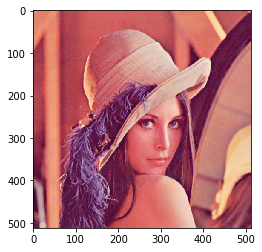

In [17]:
lena = read_im('data/lena.png')
show_im(lena)

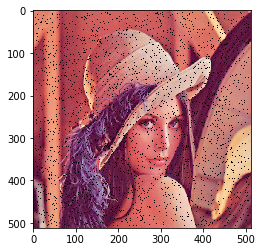

In [18]:
show_im(noise(lena,0.05,5))

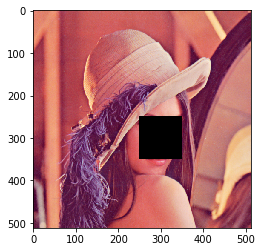

In [19]:
show_im(delete_rect(lena,250,250,100,100))

Nous avons defini les fonctions de bruitage, nous allons à présent définir les fonctions qui recupèrent les patchs bruités ou non de l'image

In [20]:
def get_all_patch(im, h, step):
    
    coordonne_centre_patch = np.array([np.array((i, j)) for i in range(h, im.shape[0] - h, step) \
                                       for j in range(h, im.shape[1] - h, step)])
    return np.array([get_patch(i, j, h, im) for (i, j) in coordonne_centre_patch])

def get_all_noise_path(im, h, step):
    return np.array([patch for patch in get_all_patch(im, h, step) if NOISE in patch])

def get_all_clear_path(im, h, step):
    return np.array([patch for patch in get_all_patch(im, h, step) if NOISE not in patch])

def patch_to_vect(patch):
    return patch.reshape(-1)

def vect_to_patch(vect):
    h = int((vect.shape[0]/3)**(0.5))
    return vect.reshape(h,h,3)

def get_next_pixel_to_fill(im,ind=0):
    masque = np.where(im == NOISE)
    return masque[0][0], masque[1][0]

def get_pixel_to_fill(im):
    masque = np.where(im == NOISE)
    return masque[0], masque[1]


##### 2.2 Si l'on a du bruit dans l'image

Ici lorsque l'on reconstruie l'image on prend simplement les pixels dans l'ordre de leurs apparitions dans la matrice.

In [21]:
def inpainting_bruit(im, h, step, alpha=0.001, max_iter=100, heuristique=get_pixel_to_fill,i=3):
    
    im_res = im.copy()
        
    pixels_to_fill = heuristique(im_res)
    
    liste_patch_clear = get_all_clear_path(im, h, step)
    dictionnaireh = np.array([patch_to_vect(patch[:,:,0]) for patch in liste_patch_clear])
    dictionnaires = np.array([patch_to_vect(patch[:,:,1]) for patch in liste_patch_clear])
    dictionnairev = np.array([patch_to_vect(patch[:,:,2]) for patch in liste_patch_clear])
    
    modelh = sklearn.linear_model.Lasso(alpha=alpha, max_iter=max_iter)
    models = sklearn.linear_model.Lasso(alpha=alpha, max_iter=max_iter)
    modelv = sklearn.linear_model.Lasso(alpha=alpha, max_iter=max_iter)
    
    for p in range(0,len(pixels_to_fill[0]),i):
        
        pixel = [pixels_to_fill[0][p], pixels_to_fill[1][p]]
        patch = get_patch(*pixel, h, im_res)
        
        patchh = patch_to_vect(patch[:,:,0])
        patchs = patch_to_vect(patch[:,:,1])
        patchv = patch_to_vect(patch[:,:,2])
        masqueh = np.where(patchh != NOISE)
        masques = np.where(patchs != NOISE)
        masquev = np.where(patchv != NOISE)

        modelh.fit(dictionnaireh.T[masqueh], patchh[masqueh])
        
        models.fit(dictionnaires.T[masques], patchs[masques])
    
        modelv.fit(dictionnairev.T[masquev], patchv[masquev])
        
        i, j = get_pos_in_patch(pixel[0],pixel[1], h, im)
        t = i * (2 * h + 1) + j
        patchh[t] = modelh.predict(dictionnaireh[:,t].T.reshape(1, -1))
        patchs[t] = models.predict(dictionnaires[:,t].T.reshape(1, -1))
        patchv[t] = modelv.predict(dictionnairev[:,t].T.reshape(1, -1))
                
        im_res[pixel[0], pixel[1]] = np.hstack((patchh[t],patchs[t],patchv[t]))
        
    return im_res
        


Pour l'image de lena buité à 1%

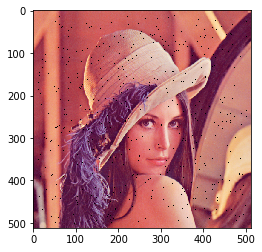

In [22]:
l2 = noise(lena,0.01,10)
show_im(l2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


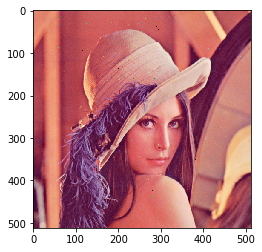

In [23]:
t = inpainting_bruit(l2,1,5,alpha=0.0001,max_iter=10)
show_im(t)

On a ce résultat pour un patch de taille 3 x 3 et un step de 5 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


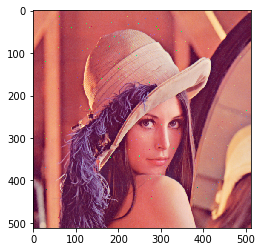

In [24]:
t = inpainting_bruit(l2,4,15,alpha=0.00001,max_iter=10)
show_im(t)

Maintenant pour un patch de taille 9 x 9, et un step de 15. Normalement augmenter la taille du patch et diminuer le step devrait nous aider à mieux reconstruire les pixels isolés sur un fond homogène. Mais ce n'est pas ce que l'on observe ici, il y a une erreur dans la fonction inpainting_bruit, puisque qu'elle prédit des valeurs de pixels supérieurs à 1 ou inferieurs à 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


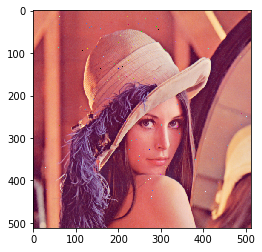

In [35]:
t = inpainting_bruit(l2,1,5,alpha=0.000001,max_iter=10)
show_im(t)

Résultat pour un patch de taille 3 x 3 et un step de 5 et un alpha égale à 10^-6

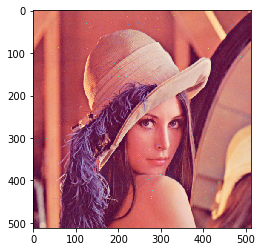

In [38]:
t = inpainting_bruit(l2,1,5,alpha=10,max_iter=10)
show_im(t)

Résultat pour un patch de taille 3 x 3 et un step de 5 et un alpha égale à 10.

Le resultat n'est pas encore parfait, mais on fait moins d'erreur de reconstruction lorsque l'on augmente le lambda qui equivaux à la pénalisation du LASSO

##### 2.3 Partie manquante de l'image

Nous allons travailler à partir de l'image suivante

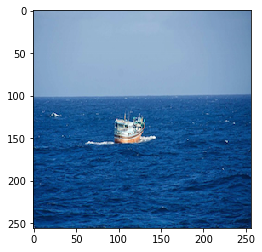

In [25]:
bateau = read_im('data/bateau.png')
show_im(bateau)

Nous allons implémenter une fonction pour traiter les pixels de l'extérieur vers l'intérieur, sachant que les images que l'on va donner à l'algorithme possède seulement un bloc de pixels noir.

Par exemple sur Bateau

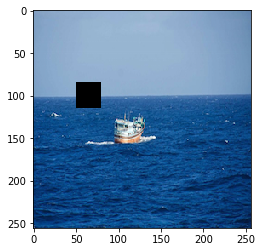

In [26]:
bateau2 =delete_rect(bateau,85,50,30,30)
show_im(bateau2)

Si l'on reconstruie avec la stratégie précédente, c'est à dire ligne par ligne, le resultat n'est pas si mauvais pour un patch de taille suffisante

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image du bateau 


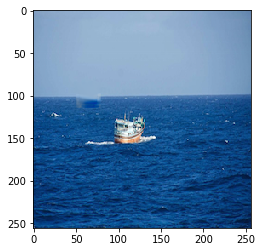

In [27]:
bateau_reconstruie = inpainting_bruit(bateau2, 5, 5, alpha=0.0001, max_iter=10, heuristique=get_pixel_to_fill)
show_im(bateau_reconstruie)

On a le résultat suivant pour un patch de taille 3 x 3 et un step de 5

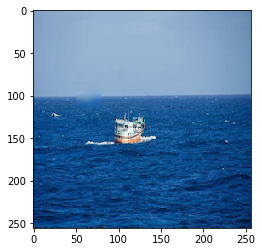

In [29]:
bateau_reconstruie = inpainting_bruit(bateau2, 15, 15, alpha=0.0001, max_iter=10, heuristique=get_pixel_to_fill)
show_im(bateau_reconstruie)

In [30]:
def get_pixel_to_fill_onion(im):
    masque = np.where(im == NOISE)
    list_x, list_y = masque[0], masque[1]
    x1, y1 = list_x[0], list_y[0]
    x2, y2 = list_x[-1], list_y[-1]
    liste_res = [] 
    get_order(x1, y1, x2, y2, liste_res)
    return np.array([x[0] for x in liste_res]), np.array([y[1] for y in liste_res])

def get_order(x1,y1,x2,y2,l):
    if x1==x2:
        l.extend((x1,y1))
        return l
    if x1 > x2:
        return l
    l.extend([(x1,y) for y in range(y1,y2+1)])
    l.extend([(x,y2) for x in range(x1+1,x2)])
    l.extend([(x2,y) for y in range(y1,y2+1)][::-1])
    l.extend([(x,y1) for x in range(x1+1,x2)][::-1])
    get_order(x1+1,y1+1,x2-1,y2-1,l)
    


Avec le nouvel ordre pour traiter les pixels manquants, le résultat est moins flou. On voie comme dans [1] que l'ordre a une importance

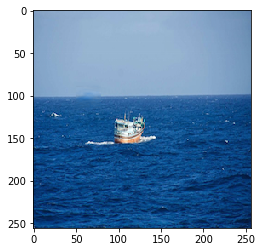

In [31]:
bateau_reconstruie = inpainting_bruit(bateau2, 13, 9, alpha=0.0001, max_iter=10, heuristique=get_pixel_to_fill_onion, i=1)
show_im(bateau_reconstruie)

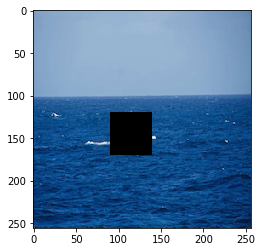

In [32]:
bateau3 =delete_rect(bateau,120,90,50,50)
show_im(bateau3)

A Présent on va essayer de faire disparaître le bateau

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


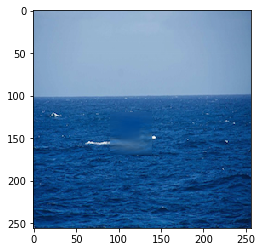

In [33]:
bateau_reconstruie = inpainting_bruit(bateau3, 15, 15, alpha=0.0001, max_iter=10, heuristique=get_pixel_to_fill)
show_im(bateau_reconstruie)

On a reconstruie avec un patch de taille 31 x 31, le bateau a bien disparu mais on voit un carré flou à la place

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


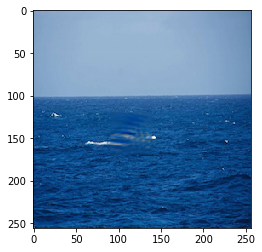

In [49]:
bateau_reconstruie = inpainting_bruit(bateau3, 13, 9, alpha=0.0001, max_iter=10, heuristique=get_pixel_to_fill_onion, i=1)
show_im(bateau_reconstruie)

On a toujours ces erreurs lors de la reconstruction. Mais on voit que lorsque l'on traite les pixels de l'extérieur vers l'intérieur, on a moins de délimitation qu'avec la technique précédente.

[1] Region Filling and Object Removal byExemplar-Based Image Inpainting, A. Criminisi*, P. P ́erez and K. ToyamaMicrosoft Research, Cambridge (UK) and Redmond (US)